In [55]:
# -*- coding: utf-8 -*-
"""
Gene-Disease Analysis with MONDO Ontology

This notebook processes gene-disease relationship data, maps diseases to MONDO IDs, 
checks for equivalence, and analyzes disease standardization.
"""

# 📌 SECTION 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [56]:
# 📌 SECTION 2: Load Excel Data

import pandas as pd

# Load the Excel file
file_path = "Clingen-Curation-Activity-Summary-Report-2025-03-01.xlsx"

# Read all sheets into a dictionary of DataFrames
df_dict = pd.read_excel(file_path, sheet_name=None)  # Loads all sheets

# Print available sheet names
print("Available sheets:", df_dict.keys())

# Accessing the correct sheet by name
sheet_name = "Clingen-Curation-Activity-Summa"  # Replace with exact sheet name
if sheet_name in df_dict:
    df = df_dict[sheet_name]  # Load the specific sheet
    print(f"Loaded sheet: {sheet_name}")
else:
    raise ValueError(f"Sheet '{sheet_name}' not found in the Excel file.")

# Print first few rows
print(df.head())

Available sheets: dict_keys(['Clingen-Curation-Activity-Summa', 'Gene2Pheno', 'LoGoFunc', 'Dominant Negative'])
Loaded sheet: Clingen-Curation-Activity-Summa
  gene_symbol     hgnc_id                                           gene_url  \
0       A2ML1  HGNC:23336  https://search.clinicalgenome.org/kb/genes/HGN...   
1       AAGAB  HGNC:25662  https://search.clinicalgenome.org/kb/genes/HGN...   
2       AARS1     HGNC:20  https://search.clinicalgenome.org/kb/genes/HGN...   
3       AARS2  HGNC:21022  https://search.clinicalgenome.org/kb/genes/HGN...   
4       AARS2  HGNC:21022  https://search.clinicalgenome.org/kb/genes/HGN...   

                                       disease_label       mondo_id  \
0                                    Noonan syndrome  MONDO:0018997   
1         palmoplantar keratoderma, punctate type 1A  MONDO:0007858   
2         Charcot-Marie-Tooth disease axonal type 2N  MONDO:0013212   
3                              mitochondrial disease  MONDO:0044970   
4  leu

In [57]:
def get_mondo_id(disease_name):
    """
    Fetches MONDO ID for a given disease using the EBI OLS API.
    
    Args:
        disease_name (str): Name of the disease.
    
    Returns:
        str or None: MONDO ID if found, otherwise None.
    """
    api_url = "https://www.ebi.ac.uk/ols/api/search"
    params = {"q": disease_name, "ontology": "mondo", "exact": "false"}
    response = requests.get(api_url, params=params)
    response.raise_for_status()
    data = response.json()
    
    if data["response"]["numFound"] > 0:
        return data["response"]["docs"][0]["obo_id"]
    return None

def get_mondo_term_data(mondo_id):
    """
    Fetches synonyms and cross-references for a given MONDO ID.
    
    Args:
        mondo_id (str): The MONDO ID.
    
    Returns:
        tuple: (synonyms, xrefs) - Both are lists, even if empty.
    """
    base_url = f"https://www.ebi.ac.uk/ols/api/ontologies/mondo/terms/http%253A%252F%252Fpurl.obolibrary.org%252Fobo%252F{mondo_id.replace(':', '_')}"
    
    response = requests.get(base_url)
    
    # Handle failed API request
    if response.status_code != 200:
        print(f"Warning: Failed to fetch data for {mondo_id}")
        return [], []  # Return empty lists instead of None

    data = response.json()
    embedded = data.get('_embedded', {}).get('terms', [])

    # Handle cases where no data is found
    if not embedded:
        print(f"Warning: No data found for {mondo_id}")
        return [], []  # Return empty lists instead of None

    term_data = embedded[0]
    synonyms = term_data.get('synonyms', [])
    xrefs = term_data.get('annotation', {}).get('database_cross_reference', [])

    return synonyms, xrefs


def check_mondo_equivalence(mondo_id1, mondo_id2):
    """
    Determines if two MONDO terms refer to the same disease.
    
    Args:
        mondo_id1 (str): First MONDO ID.
        mondo_id2 (str): Second MONDO ID.
    
    Returns:
        tuple: (boolean, shared_synonyms, shared_xrefs)
    """
    synonyms1, xrefs1 = get_mondo_term_data(mondo_id1) or ([], [])
    synonyms2, xrefs2 = get_mondo_term_data(mondo_id2) or ([], [])

    common_synonyms = set(synonyms1).intersection(synonyms2)
    common_xrefs = set(xrefs1).intersection(xrefs2)

    return bool(common_synonyms or common_xrefs), common_synonyms, common_xrefs


In [58]:
# 📌 SECTION 4: Data Processing Functions

def sample_data(df, p=0.1):
    """
    Returns a random sample of the dataset.
    
    Args:
        df (pd.DataFrame): The full dataset.
        p (float): Proportion of rows to sample.
    
    Returns:
        pd.DataFrame: Sampled dataset.
    """
    mask = np.random.rand(len(df)) < p  # Randomly select rows
    return df[mask]

def find_duplicate_gene_disease_pairs(df):
    """
    Checks for duplicate (hgnc_id, mondo_id) pairs in a dataset.
    
    Args:
        df (pd.DataFrame): The dataset.
    
    Returns:
        pd.DataFrame: DataFrame with duplicate rows.
    """
    duplicates = df[df.duplicated(subset=["hgnc_id", "mondo_id"], keep=False)]
    return duplicates

In [59]:
# 📌 SECTION 5: Data Analysis

def analyze_disease_frequency(df):
    """
    Plots the top 10 most frequently occurring diseases in the dataset.
    
    Args:
        df (pd.DataFrame): The dataset.
    """
    disease_counts = df["disease_label"].value_counts().head(10)

    plt.figure(figsize=(10,5))
    sns.barplot(x=disease_counts.values, y=disease_counts.index)
    plt.xlabel("Number of Associated Genes")
    plt.ylabel("Disease Label")
    plt.title("Top 10 Most Studied Diseases")
    plt.show()

def analyze_mondo_mapping(df):
    """
    Plots the proportion of diseases mapped to MONDO IDs.
    
    Args:
        df (pd.DataFrame): The dataset.
    """
    df["mondo_mapped"] = df["mondo_id"].apply(lambda x: 1 if pd.notna(x) else 0)
    
    df["mondo_mapped"].value_counts().plot(kind="bar", color=["red", "green"])
    plt.xticks(ticks=[0,1], labels=["Unmapped", "Mapped"], rotation=0)
    plt.title("Proportion of Diseases Mapped to MONDO IDs")
    plt.ylabel("Count")
    plt.show()

No duplicate gene-disease pairs found.


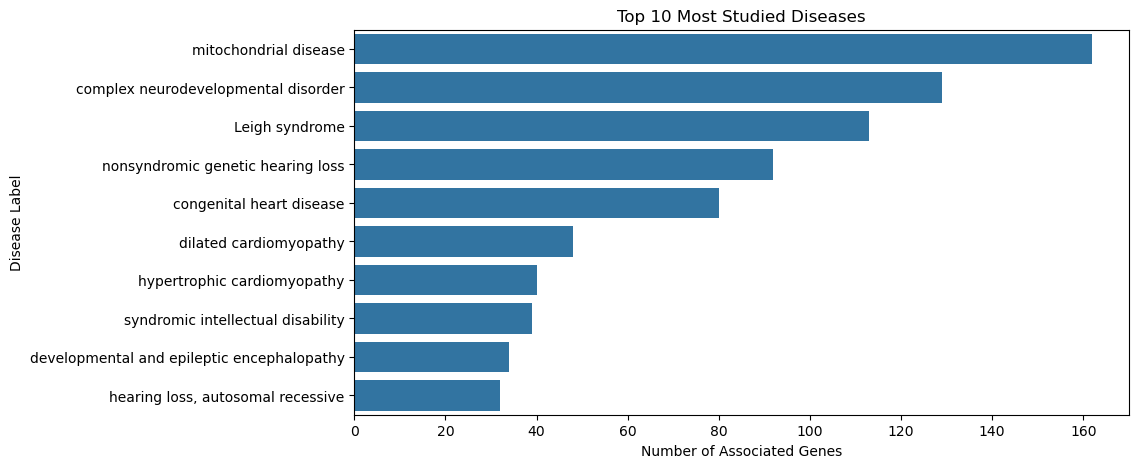

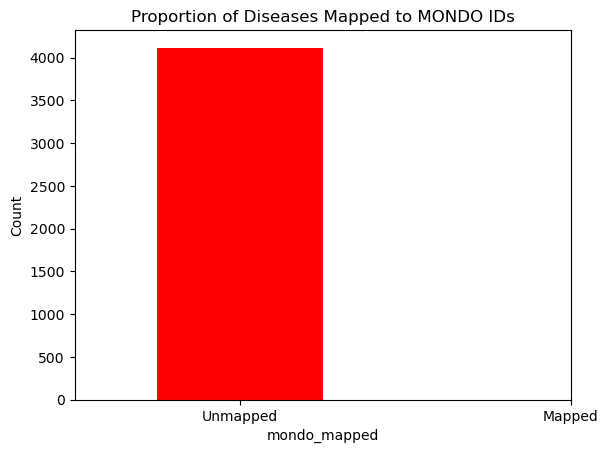

Are MONDO:0018544 and MONDO:0010247 equivalent? False


In [61]:
# 📌 SECTION 6: Execution - Process Data and Perform Analysis

# Sample the dataset (10% sample)
sample_df = sample_data(df, 0.1)

# Check for duplicates
duplicates = find_duplicate_gene_disease_pairs(df)
if not duplicates.empty:
    print("Duplicate gene-disease pairs found:")
    print(duplicates[["hgnc_id", "mondo_id"]])
else:
    print("No duplicate gene-disease pairs found.")

# Analyze data
analyze_disease_frequency(df)
analyze_mondo_mapping(df)

# Check MONDO equivalence for two example diseases
mondo_id1 = 'MONDO:0018544'
mondo_id2 = 'MONDO:0010247'
equivalent, shared_synonyms, shared_xrefs = check_mondo_equivalence(mondo_id1, mondo_id2)

print(f"Are {mondo_id1} and {mondo_id2} equivalent? {equivalent}")
if shared_synonyms:
    print(f"Shared synonyms: {shared_synonyms}")
if shared_xrefs:
    print(f"Shared cross-references: {shared_xrefs}")